# Transcript Analysis

In [1]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import tqdm
import pickle
import datetime
import pandas as pd
import seaborn as sns
from utils import fuzzy_lookup
import matplotlib.pyplot as plt
from collections import defaultdict

In [26]:
def print_all_authors():
	transcript_dir_path = '_Transcripts'
	print('All Podcasts:')
	for dir in os.listdir(transcript_dir_path):
		if os.path.isdir(os.path.join(transcript_dir_path, dir)):
			print(f'  {dir:>50}: {len(os.listdir(os.path.join(transcript_dir_path, dir))):<4} transcripts')

def find_transcripts(author_names, transcript_dir_path = '_Transcripts'):
	print_all_authors()
	transcript_paths_dict = defaultdict(list)
	if author_names == 'all' or author_names == ['all']:
		author_names = [dir for dir in os.listdir(transcript_dir_path) if os.path.isdir(os.path.join(transcript_dir_path, dir))]
		print(f'Finding all transcripts for {author_names}.')
	for dir in os.listdir(transcript_dir_path):
		# check if dir and if author_name is in dir
		for author_name in author_names:
			if os.path.isdir(os.path.join(transcript_dir_path, dir)) and author_name in dir:
				print(f'Found {author_name} in {transcript_dir_path}/{dir}.')
				for file in sorted(os.listdir(os.path.join(transcript_dir_path, dir)), reverse=True):
					transcript_paths_dict[author_name].append(os.path.join(transcript_dir_path, dir, file))
				print(f' Found {len(transcript_paths_dict[author_name])} transcripts.')
	if len(transcript_paths_dict[author_name]) == 0:
		print(f'No transcripts found for {author_name}.')
		sys.exit(1)
	else:
		transcript_paths_all = [transcript for author_name, transcripts in transcript_paths_dict.items() for transcript in transcripts]
		print(f'Found {len(transcript_paths_all)} total transcripts for {author_names}.')
	return transcript_paths_dict

def extract_yaml_front_matter(f, transcript_dict):
	# default meta keys
	default_keys = ['Date Generated', 'Transcription Model', 'Length', 'Video Keywords', 'Video Views', 'Video Rating', 'Video Description']
	# capture all the meta data until the next --- is found
	meta_data = ''
	meta_dict = defaultdict(str)
	for line in f:
		if line == '---\n':
			break
		meta_data += line
	# extract all the information with 'header' : 'value' format
	meta_data = meta_data.split('\n')
	for data in meta_data:
		if data != '' and len(data.split(': ')) == 2:
			header, value = data.split(': ')
			# check if value is an int and convert it
			try:
				value = int(value)
			except:
				pass
			meta_dict[header] = value
	# remove keys not in default_keys
	for key in list(meta_dict.keys()):
		if key not in default_keys:
			meta_dict.pop(key)
	# rename keys to lowercase and remove spaces with underscores
	for key in list(meta_dict.keys()):
		meta_dict[key.lower().replace(' ', '_')] = meta_dict.pop(key)
	return meta_dict

def read_transcript(author_name, transcript_name, transcript_dict):
		# deal with UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 304: character maps to <undefined> errors
	with open(transcript_name, 'r', encoding='utf-8') as f:
		print(f'  Reading: {transcript_name}')
		meta_flag = False
		meta_dict = defaultdict(str)
		for line in f:
			# read the .md meta data in YAML Front Matter format --- 
			if line == '---\n' and not meta_flag:
				meta_dict = extract_yaml_front_matter(f, transcript_dict)
				meta_flag = True
			# title is the first line of the transcript, with # at the beginning
			elif line[0] == '#':
				meta_flag = False
				title = line[1:].strip()
				transcript_dict[title]['podcast'] = author_name
			# date is in the second line of the transcript, between [ and ]
			# url is in the second line of the transcript, between ( and )
			elif line[:2] == '**':
				date = re.search(r'\[(.*?)\]', line).group(1)
				# conver date to datetime (December 6, 2023 -> 2023-12-06)
				date = datetime.datetime.strptime(date, '%B %d, %Y').strftime('%Y-%m-%d')
				# add year, month, day to the dict
				year = date[:4]
				month = date[5:7]
				day = date[8:]
				transcript_dict[title]['date'] = date
				transcript_dict[title]['year'] = year
				transcript_dict[title]['month'] = month
				transcript_dict[title]['day'] = day
				transcript_dict[title]['date'] = date
				# convert date to day of the week
				weekday = datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')
				transcript_dict[title]['weekday'] = weekday
				url = re.search(r'\((.*?)\)', line).group(1)
				transcript_dict[title]['url'] = url
			elif not meta_flag:
				# add the line to the transcript (taking out leading * and other formatting including ' and ")
				transcript_dict[title]['transcript'].append(str(line[3:].strip()))
		if len(meta_dict) > 0:
			for key, value in meta_dict.items():
				transcript_dict[title][key] = value
		return transcript_dict

def dict_to_pandas(transcript_dict):
	# initialize the dataframe
	transcript_df = pd.DataFrame()
	for title, content in transcript_dict.items():
		# add the title to the content at the beginning
		content['title'] = title
		transcript_df = pd.concat([transcript_df, pd.DataFrame([content])], ignore_index=True)
	# sort by year, month, day and reset the index
	transcript_df = transcript_df.sort_values(by=['year', 'month', 'day'], ascending=False, ignore_index=True)
	# move Title to the front of the dataframe
	cols = transcript_df.columns.tolist()
	cols = cols[-1:] + cols[:-1]
	transcript_df = transcript_df[cols]
	# transcript_df['Video Views'] = transcript_df['Video Views'].str.replace(',', '').astype(int)
	return transcript_df

def pickle_transcript_df(transcript_df, author_name):
	print(f'Pickling {author_name} transcript_df.')
	dataframe_dir_path = '_Dataframes'
	if not os.path.exists(dataframe_dir_path):
		os.makedirs(dataframe_dir_path)
	transcript_df_name = f'{author_name}_transcript_df.pickle'
	df_path = os.path.join(dataframe_dir_path, transcript_df_name)
	with open(df_path, 'wb') as f:
		pickle.dump(transcript_df, f)
		print(f' Pickled {transcript_df_name} in {dataframe_dir_path}/.')

def dataframe_exists(author_name):
	dataframe_dir_path = '_Dataframes'
	for file in os.listdir(dataframe_dir_path):
		if author_name in file:
			return True
	return False

# rename every file in _Transcripts/<author> from <date>_* to <date>_<author>.md
def rename_files(author_name = 'Democracy Now Headlines'):
	transcript_dir_path = '_Transcripts'
	for file in os.listdir(os.path.join(transcript_dir_path, author_name)):
		if '.md' in file:
			date = file.split('_')[0]
			new_file = f'{date}_{author_name}.md'
			print(f'Renaming {file} to {new_file}.')
			os.rename(os.path.join(transcript_dir_path, author_name, file), 
						 		os.path.join(transcript_dir_path, author_name, new_file))

def main(author_names = ['New York Times'], reload=True, save_df=False):
	# author_name = sys.argv[1]
	for author_name in author_names:
		print(f'Searching for {author_name} transcripts...')
		# check if the dataframe exists
		if dataframe_exists(author_name) and not reload:
			print(f'Found: transcript_df already exists.')
			dataframe_dir_path = os.path.join('_Dataframes', f'{author_name}_transcript_df.pickle')
			print(f'  Loading \'{dataframe_dir_path}\'...')
			with open(dataframe_dir_path, 'rb') as f:
				transcript_df = pickle.load(f)
				print(f'  Number of transcripts: {len(transcript_df)}.')
		# if the dataframe does not exist, create it by reading the transcripts
		transcript_paths_dict = find_transcripts(author_names)
		transcripts_dict = defaultdict(lambda: defaultdict(list))
		for author_name, transcripts in transcript_paths_dict.items():
			for transcript in transcripts:
				if '.md' in transcript:
					transcripts_dict = read_transcript(author_name, transcript, transcripts_dict)
		transcript_df = dict_to_pandas(transcripts_dict)
	if save_df:
		pickle_transcript_df(transcript_df, author_name)
	return transcript_df

def check_for_fuzzy_columns(transcript_df, target_word_list):
	filtered_target_word_list = []
	exclusion_list = []
	for word in target_word_list:
		if f'max_fuzzy_{word}' in transcript_df.columns:
			exclusion_list.append(word)
			# remove the word from the target_word_list
		else:
			filtered_target_word_list.append(word)
	print(f'Excluding the following words already in the dataset: ')
	print(f'  {exclusion_list}')
	return filtered_target_word_list

def topic_search(transcript_df, target_word_list, fuzzy_threshold=0.85):
	print('Performing fuzzy search for the following words:')
	print(f'  {target_word_list}')
	# check to see if the target words are already in the transcript_df
	target_word_list_filtered = check_for_fuzzy_columns(transcript_df, target_word_list)
	max_fuzzy_list = defaultdict(list)
	max_fuzzy_word_list = defaultdict(list)

	for idx, transcript in enumerate(transcript_df['transcript']):
		podcast_channel = transcript_df.iloc[idx]['podcast']
		pod_title = transcript_df.iloc[idx]['title']	
		pod_date = transcript_df.iloc[idx]['year'] + '-' + transcript_df.iloc[idx]['month'] + '-' + transcript_df.iloc[idx]['day']
		print(f'{podcast_channel} - {pod_date}: {pod_title}')
		for t_index, target_word in enumerate(target_word_list_filtered):
			max_fuzzy, max_fuzzy_word = fuzzy_lookup.fuzzy_matching(target_word, transcript, fuzzy_threshold)
			max_fuzzy_list[target_word].append(max_fuzzy)
			max_fuzzy_word_list[target_word].append(max_fuzzy_word)
	# add the max_fuzzy and max_fuzzy_word to the transcript_df
	for key in max_fuzzy_list.keys():
		transcript_df[f'max_fuzzy_{key}'] = max_fuzzy_list[key]
		transcript_df[f'max_fuzzy_word_{key}'] = max_fuzzy_word_list[key]
	return transcript_df

In [14]:
# print all the different authors
print_all_authors()

All Podcasts:
                                            a16z Bio: 28   transcripts
                                     Andrew Huberman: 223  transcripts
                                         BBC Archive: 1    transcripts
                                    Bill Simmons NBA: 212  transcripts
                                    Bill Simmons NFL: 97   transcripts
                                      Brain Inspired: 189  transcripts
               Chomskys Philosophy - Best of Chomsky: 150  transcripts
                                Cognitive Revolution: 139  transcripts
                             Conversation with Tyler: 21   transcripts
                                       Democracy Now: 45   transcripts
                             Democracy Now Headlines: 153  transcripts
                                      Empire Podcast: 29   transcripts
                                         Lex Fridman: 349  transcripts
                                   Mindscape Podcast: 335  tran

***
## Example 1: New York Times - Middle Eastern Coverage

In [27]:
author_names = ['all']
transcript_df = main(author_names)

Searching for all transcripts...
All Podcasts:
                                            a16z Bio: 28   transcripts
                                     Andrew Huberman: 223  transcripts
                                         BBC Archive: 1    transcripts
                                    Bill Simmons NBA: 212  transcripts
                                    Bill Simmons NFL: 97   transcripts
                                      Brain Inspired: 189  transcripts
               Chomskys Philosophy - Best of Chomsky: 150  transcripts
                                Cognitive Revolution: 139  transcripts
                             Conversation with Tyler: 21   transcripts
                                       Democracy Now: 45   transcripts
                             Democracy Now Headlines: 153  transcripts
                                      Empire Podcast: 29   transcripts
                                         Lex Fridman: 349  transcripts
                              

In [33]:
# reverse the order of the x-axis
# show all columns
pd.set_option('display.max_columns', None)
transcript_df = transcript_df.sort_values(by='video_views', ascending=False, ignore_index=True)
transcript_df

,title,podcast,date,year,month,day,weekday,url,transcript,date_generated,transcription_model,length,video_keywords,video_views,video_rating,video_description,max_fuzzy_Gaza,max_fuzzy_word_Gaza,max_fuzzy_West Bank,max_fuzzy_word_West Bank,max_fuzzy_Palestine,max_fuzzy_word_Palestine,max_fuzzy_Israel,max_fuzzy_word_Israel
0,Andrew Bustamante: CIA Spy | Lex Fridman Podca...,Lex Fridman,2022-08-08,2022,08,08,Monday,https://www.youtube.com/watch?v=T3FC7qIAGZk,"[Mossad will do anything., Mossad has no qualm...","April 10, 2024",whisper medium 20231117,13989s,"['agi', 'ai', 'ai podcast', 'andrew bustamante...",15755826.0,None,NaN,0.750000,gaze,0.823529,West and,0.750000,palette,0.923077,Israeli
1,"Jordan Peterson: Life, Death, Power, Fame, and...",Lex Fridman,2022-08-19,2022,08,19,Friday,https://www.youtube.com/watch?v=sY8aFSY2zv4,"[Если ты сражаешься с монстром, то сам станови...","April 10, 2024",whisper medium 20231117,11013s,"['Canada', 'Dostoevsky', 'Justin Trudeau', 'Ni...",14503977.0,None,NaN,0.222222,Daily,0.315789,Wire сразу,0.375000,special,0.600000,Wire
2,"Tucker Carlson: Putin, Navalny, Trump, CIA, NS...",Lex Fridman,2024-02-27,2024,02,27,Tuesday,https://www.youtube.com/watch?v=f_lRdkH_QoY,"[Он сказал очень конкретно, в зависимости от т...","April 08, 2024",whisper medium 20231117,11062s,"['agi', 'ai', 'ai podcast', 'artificial intell...",12510646.0,None,NaN,0.400000,Garden,0.470588,News CNN,0.500000,Carlson,0.500000,Square
3,"Joe Rogan: Comedy, Controversy, Aliens, UFOs, ...",Lex Fridman,2022-07-04,2022,07,04,Monday,https://www.youtube.com/watch?v=gk4tEO4jDUM,[The following is a conversation with Joe Roga...,"April 10, 2024",whisper medium 20231117,6081s,"['agi', 'ai', 'ai podcast', 'artificial intell...",10486711.0,None,NaN,0.666667,Lazar,0.705882,we break,0.705882,pleasing,0.714286,insanely
4,Dr. Paul Conti: How to Understand & Assess You...,Andrew Huberman,2023-09-06,2023,09,06,Wednesday,https://www.youtube.com/watch?v=tLRCS48Ens4,"[Welcome to the Huberman Lab guest series,, wh...","April 27, 2024",whisper medium 20231117,13370s,"['andrew huberman', 'huberman lab podcast', 'h...",10474554.0,None,NaN,0.571429,gas,0.705882,best and,0.666667,please,0.666667,dispel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,The Oregon Trail & the Gold Rush,Empire Podcast,2024-06-25,2024,06,25,Tuesday,https://www.youtube.com/watch?v=cmXYZVEVSv8,"[If you want access to bonus episodes, reading...","June 25, 2024",whisper medium 20231117,2694s,[],12.0,None,Fort Laramie was once a stockade where Europea...,0.545455,Grattan,0.823529,west and,0.631579,Clementine,0.714286,insanely
2834,"""Toward Nakba as a Legal Concept"": Meet the Pa...",Democracy Now Headlines,2024-06-05,2024,06,05,Wednesday,https://www.youtube.com/watch?v=jVdmtMimQvg,"[This news is funded by viewers like you., Ple...","June 05, 2024",whisper medium 20231117,858s,"['Democracy Now', 'Amy Goodman', 'News', 'Poli...",3.0,None,NaN,1.000000,Gaza,1.000000,West Bank,1.000000,Palestine,0.923077,Israeli
2835,"Annie Jacobsen: Nuclear War, CIA, KGB, Aliens,...",Lex Fridman,2024-03-22,2024,03,22,Friday,https://rr4---sn-ab5sznze.googlevideo.com/vide...,"[The United States has 1,770 nuclear weapons d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,galaxy,0.823529,West and,0.666667,please,0.666667,insane
2836,"Sam Altman: OpenAI, GPT-5, Sora, Board Saga, E...",Lex Fridman,2024-03-18,2024,03,18,Monday,https://rr3---sn-ab5sznzd.googlevideo.com/vide...,[I think compute is going to be the currency o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,saga,0.705882,get back,0.666667,please,0.666667,visual


In [29]:
# perform fuzzy match for all words in target_word_list
target_word_list = ['Gaza', 'West Bank', 'Palestine', 'Israel']
fuzzy_threshold = 0.85
topic_df = topic_search(transcript_df, target_word_list, fuzzy_threshold)


Performing fuzzy search for the following words:
  ['Gaza', 'West Bank', 'Palestine', 'Israel']
Excluding the following words already in the dataset: 
  []
2024-09-12: Top U.S. & World Headlines — September 12, 2024
  "Gaza" Match Score: 1.0    | Match: Gaza
  "West Bank" Match Score: 1.0    | Match: West Bank
  "Palestine" Match Score: 0.8    | Match: Palestinian
  "Israel" Match Score: 0.9231 | Match: Israeli
2024-09-12: How the Election Is Sinking a $15 Billion Business Deal
  "Gaza" Match Score: 0.5    | Match: Alan
  "West Bank" Match Score: 0.7    | Match: Midwest and
  "Palestine" Match Score: 0.625  | Match: pension
  "Israel" Match Score: 0.625  | Match: industrial
2024-09-12: Gregory Aldrete The Roman Empire - Rise and Fall of Ancient Rome  Lex Fridman Podcast #443
  "Gaza" Match Score: 0.5    | Match: away
  "West Bank" Match Score: 0.7778 | Match: went back
  "Palestine" Match Score: 0.7059 | Match: prestige
  "Israel" Match Score: 0.6667 | Match: itself
2024-09-11: Is Deio

In [34]:
topic_df.head(50)

,title,podcast,date,year,month,day,weekday,url,transcript,date_generated,transcription_model,length,video_keywords,video_views,video_rating,video_description,max_fuzzy_Gaza,max_fuzzy_word_Gaza,max_fuzzy_West Bank,max_fuzzy_word_West Bank,max_fuzzy_Palestine,max_fuzzy_word_Palestine,max_fuzzy_Israel,max_fuzzy_word_Israel
0,"Top U.S. & World Headlines — September 12, 2024",Democracy Now Headlines,2024-09-12,2024,09,12,Thursday,https://www.youtube.com/watch?v=cFC1BJ_n_j4,"[Welcome to Democracy Now!, democracynow.org, ...","September 12, 2024",whisper medium 20231117,571s,"['Democracy Now', 'Amy Goodman', 'News', 'Poli...",33356.0,None,NaN,1.000000,Gaza,1.000000,West Bank,0.800000,Palestinian,0.923077,Israeli
1,How the Election Is Sinking a $15 Billion Busi...,New York Times Podcasts,2024-09-12,2024,09,12,Thursday,https://www.youtube.com/watch?v=eIX8o8Volxk,"[From the New York Times, I'm Sabrina Tavernis...","September 12, 2024",whisper medium 20231117,1223s,[],2224.0,None,"In a highly unusual move, the Biden administra...",0.500000,Alan,0.700000,Midwest and,0.625000,pension,0.625000,industrial
2,Gregory Aldrete The Roman Empire - Rise and Fa...,Lex Fridman,2024-09-12,2024,09,12,Thursday,https://www.youtube.com/watch?v=DyoVVSggPjY,[So Rome always wins because even if they lose...,"September 13, 2024",whisper medium 20231117,13341s,"['Gregory Aldrete', 'alex friedman', 'lex ai',...",112780.0,None,Gregory Aldrete is a historian specializing in...,0.500000,away,0.777778,went back,0.705882,prestige,0.666667,itself
3,Is Deion Sanders Doomed at Colorado? With Van ...,Bill Simmons NFL,2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=TBLq3sn4Zn4,"[All right. Since we have been on the pod, we ...","September 12, 2024",whisper medium 20231117,552s,"['Bill Simmons', 'Bill Simmons Podcast', 'The ...",33737.0,None,The Ringer’s Bill Simmons is joined by Van Lat...,0.500000,game,0.625000,was and,0.625000,athlete,0.600000,same
4,Harris Baits Trump Inside Their Fiery Debate,New York Times Podcasts,2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=I7JDBK1t-xo,"[From New York Times, I'm Michael Boborjo., Th...","September 12, 2024",whisper medium 20231117,2225s,[],42654.0,None,In their first and possibly only presidential ...,0.666667,Gaetz,0.705882,get back,0.631579,questioner,0.666667,rarely
5,"Harris Had a Theory of Trump, and It Was Right",The Ezra Klein Show,2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=oRWJ0aY2n_Q,"[From New York Times opinion, this is the Ezra...","September 12, 2024",whisper medium 20231117,2795s,[],88232.0,None,NaN,0.571429,gas,0.666667,get an,0.625000,parties,0.666667,miserable
6,BI 193 Kim Stachenfeld Enhancing Neuroscience ...,Brain Inspired,2024-09-10,2024,09,10,Tuesday,https://www.youtube.com/watch?v=vqNyi5ODw20,[Not only is neuroscience inspired AI not real...,"September 12, 2024",whisper medium 20231117,5532s,[],418.0,None,NaN,0.500000,grab,0.705882,we brand,0.666667,milestone,0.666667,visual
7,"Top U.S. & World Headlines — September 10, 2024",Democracy Now Headlines,2024-09-10,2024,09,10,Tuesday,https://www.youtube.com/watch?v=ZhRHYQugdpg,"[Welcome to Democracy Now!, democracynow.org, ...","September 10, 2024",whisper medium 20231117,769s,"['Democracy Now', 'Amy Goodman', 'News', 'Poli...",81267.0,None,NaN,1.000000,Gaza,1.000000,West Bank,1.000000,Palestine,1.000000,Israel
8,Judge Delays Trump Sentencing Until After Elec...,New York Times Podcasts,2024-09-10,2024,09,10,Tuesday,https://www.youtube.com/watch?v=RF8GWuq4k7Q,"[From the New York Times, I'm Sabrina Tavernis...","September 10, 2024",whisper medium 20231117,1188s,[],3451.0,None,"Last week, a judge in Manhattan announced that...",0.571429,gag,0.600000,request and,0.666667,please,0.666667,itself
9,Israels' FORGED Documents Exposed - The Lies N...,Owen Jones - Palestine,2024-09-10,2024,09,10,Tuesday,https://www.youtube.com/watch?v=iRZxUAUvuSg,[The Israeli authorities lie and lie and lie a...,"September 12, 2024",wh

In [35]:
# make a scatter plot for each date whether the target words are in the transcript
sns.set_style("ticks")
plt.figure(figsize=(18, 4))
dates = topic_df['date']
# for each date, see if each of the target words is in the transcript (has a max_fuzzy > 0.9)
# if it is, add 1 to the count
colors = ['green', 'red', 'blue']
for date in tqdm.tqdm(sorted(dates), desc='Dates'):
		date_df = topic_df[topic_df['date'] == date]
		for idx, word in enumerate(target_word_list):
			if date_df[f'max_fuzzy_{word}'].max() > 0.9:
				plt.scatter(date, 10-idx, color=colors[idx], s=30, alpha=0.5, label=word)
plt.xticks(rotation=90, fontsize=8)
plt.title(f'{author_names} Topic Search')
# only show the legend for each word once, not for each date
# get the handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()

Dates:   0%|          | 6/2838 [00:00<00:03, 745.41it/s]


IndexError: list index out of range

<Figure size 1800x400 with 0 Axes>

In [52]:
# make a grouped bar plot for the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
# and the number of rows with the topic word with max_fuzzy > 0.9
# make a plot as to the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
sns.set_theme(style="whitegrid")
plt.figure(figsize=(2, 4))
hosts = target_word_list[:2]
topic = target_word_list[4]
# for each host find the number of rows with max_fuzzy > 0.9 and plot
for h_idx, host in enumerate(hosts):
	spacing = 0
	if h_idx > 0:
		spacing = 1
	# find the number of rows with max_fuzzy > 0.9 for the host
	host_df = transcript_df[transcript_df[f'max_fuzzy_{host}'] > 0.85]
	# find the number of rows with max_fuzzy > 0.9 for the topic
	topic_df = host_df[host_df[f'max_fuzzy_{topic}'] > 0.85]
	num_shows = host_df.shape[0]
	num_shows_topic = topic_df.shape[0]
	# plot as double bar graph with host and topic
	if h_idx == 0:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7, label='Number of Shows')
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7, label=f'Number of Shows on {topic}')
	else:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7)
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7)
plt.xticks([0, 2], hosts)
# rotate the x-axis labels
plt.xticks(rotation=45)
# legend outside of box outer right and smaller font size using bbox_to_anchor
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.ylabel('Number of Podcasts')
# only keep horizontal grid
plt.grid(axis='x')

IndexError: list index out of range

<Figure size 200x400 with 0 Axes>

***
## Example 2: Bill Simmons - NBA Teams

In [11]:
author_names = ['Bill Simmons NFL']
transcript_df = main(author_names)

Searching for B transcripts...
Searching for i transcripts...
Searching for l transcripts...
Searching for l transcripts...
Searching for   transcripts...
Searching for S transcripts...
Searching for i transcripts...
Searching for m transcripts...
Searching for m transcripts...
Searching for o transcripts...
Searching for n transcripts...
Searching for s transcripts...
Searching for   transcripts...
Searching for N transcripts...
Searching for F transcripts...
Searching for L transcripts...
All Podcasts:
                                            a16z Bio: 28   transcripts
                                     Andrew Huberman: 223  transcripts
                                         BBC Archive: 1    transcripts
                                    Bill Simmons NBA: 212  transcripts
                                    Bill Simmons NFL: 97   transcripts
                                      Brain Inspired: 189  transcripts
               Chomskys Philosophy - Best of Chomsky: 150  trans

In [12]:
transcript_df

,title,date,year,month,day,weekday,url,transcript,date_generated,transcription_model,length,video_keywords,video_views,video_rating,video_description
0,"Top U.S. & World Headlines — September 12, 2024",2024-09-12,2024,09,12,Thursday,https://www.youtube.com/watch?v=cFC1BJ_n_j4,"[Welcome to Democracy Now!, democracynow.org, ...","September 12, 2024",whisper medium 20231117,571s,"['Democracy Now', 'Amy Goodman', 'News', 'Poli...",33356.0,None,NaN
1,How the Election Is Sinking a $15 Billion Busi...,2024-09-12,2024,09,12,Thursday,https://www.youtube.com/watch?v=eIX8o8Volxk,"[From the New York Times, I'm Sabrina Tavernis...","September 12, 2024",whisper medium 20231117,1223s,[],2224.0,None,"In a highly unusual move, the Biden administra..."
2,Is Deion Sanders Doomed at Colorado? With Van ...,2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=TBLq3sn4Zn4,"[All right. Since we have been on the pod, we ...","September 12, 2024",whisper medium 20231117,552s,"['Bill Simmons', 'Bill Simmons Podcast', 'The ...",33737.0,None,The Ringer’s Bill Simmons is joined by Van Lat...
3,Harris Baits Trump Inside Their Fiery Debate,2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=I7JDBK1t-xo,"[From New York Times, I'm Michael Boborjo., Th...","September 12, 2024",whisper medium 20231117,2225s,[],42654.0,None,In their first and possibly only presidential ...
4,"Harris Had a Theory of Trump, and It Was Right",2024-09-11,2024,09,11,Wednesday,https://www.youtube.com/watch?v=oRWJ0aY2n_Q,"[From New York Times opinion, this is the Ezra...","September 12, 2024",whisper medium 20231117,2795s,[],88232.0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,Noam Chomsky - Innate Language,2014-10-06,2014,10,06,Monday,https://www.youtube.com/watch?v=XyaDTxGC-wI,[My own studies in language and human cognitio...,"May 24, 2024",whisper medium 20231117,227s,"['Linguistics', 'Language', 'Speech', 'Noam Ch...",21160.0,None,NaN
2833,Noam Chomsky on Liberalism,2014-09-30,2014,09,30,Tuesday,https://www.youtube.com/watch?v=yNSgNF4vFeU,[Let me begin by saying something about libera...,"May 24, 2024",whisper medium 20231117,230s,"['von Humboldt', 'Mill', 'Liberalism', 'Chomsk...",109416.0,None,NaN
2834,Noam Chomsky on Democracy,2014-09-28,2014,09,28,Sunday,https://www.youtube.com/watch?v=Oh_Zk6Da9fU,[The political system increasingly functions w...,"May 24, 2024",whisper medium 20231117,507s,"['Democracy', 'Noam Chomsky', 'Politics', 'Cho...",188809.0,None,NaN
2835,Noam Chomsky - Legal vs Illegal,2014-09-27,2014,09,27,Saturday,https://www.youtube.com/watch?v=9w_mTXrGe-E,[One does not necessarily allow the state to d...,"May 24, 2024",whisper medium 20231117,243s,"['Anarchism', 'State', 'Imperialism', 'Philoso...",117184.0,None,NaN


In [23]:
# perform fuzzy match for all words in target_word_list
target_word_list = ['lakers', 'clippers', 'warriors', 'suns', 'kings', 
                    'mavericks', 'rockets', 'grizzlies', 'pelicans', 'spurs', 
                    'timberwolves', 'thunder', 'nuggets', 'jazz', 'blazers',
								 		'heat', 'magic', 'wizards', 'hawks', 'hornets', 'nets', 
                    'celtics', 'knicks', '76ers', 'bucks', 'pacers', 
                    'pistons', 'bulls', 'cavaliers', 'raptors']
fuzzy_threshold = 0.85
transcript_df = topic_search(transcript_df, target_word_list, fuzzy_threshold)

Performing fuzzy search for the following words:
  ['lakers', 'clippers', 'warriors', 'suns', 'kings', 'mavericks', 'rockets', 'grizzlies', 'pelicans', 'spurs', 'timberwolves', 'thunder', 'nuggets', 'jazz', 'blazers', 'heat', 'magic', 'wizards', 'hawks', 'hornets', 'nets', 'celtics', 'knicks', '76ers', 'bucks', 'pacers', 'pistons', 'bulls', 'cavaliers', 'raptors']
Excluding the following words already in the dataset: 
  []
2024-06-05: NBA Finals Bets with Cousin Sal and Joe House | The Bill Simmons Podcast
  "lakers" Match Score: 0.7692 | Match: players
  "clippers" Match Score: 1.0    | Match: Clippers
  "warriors" Match Score: 1.0    | Match: Warriors
  "suns" Match Score: 0.8    | Match: sounds
  "kings" Match Score: 0.8889 | Match: king
  "mavericks" Match Score: 1.0    | Match: Mavericks
  "rockets" Match Score: 0.7143 | Match: tickets
  "grizzlies" Match Score: 0.5714 | Match: tries
  "pelicans" Match Score: 0.6667 | Match: Celtics
  "spurs" Match Score: 0.7273 | Match: sports
  

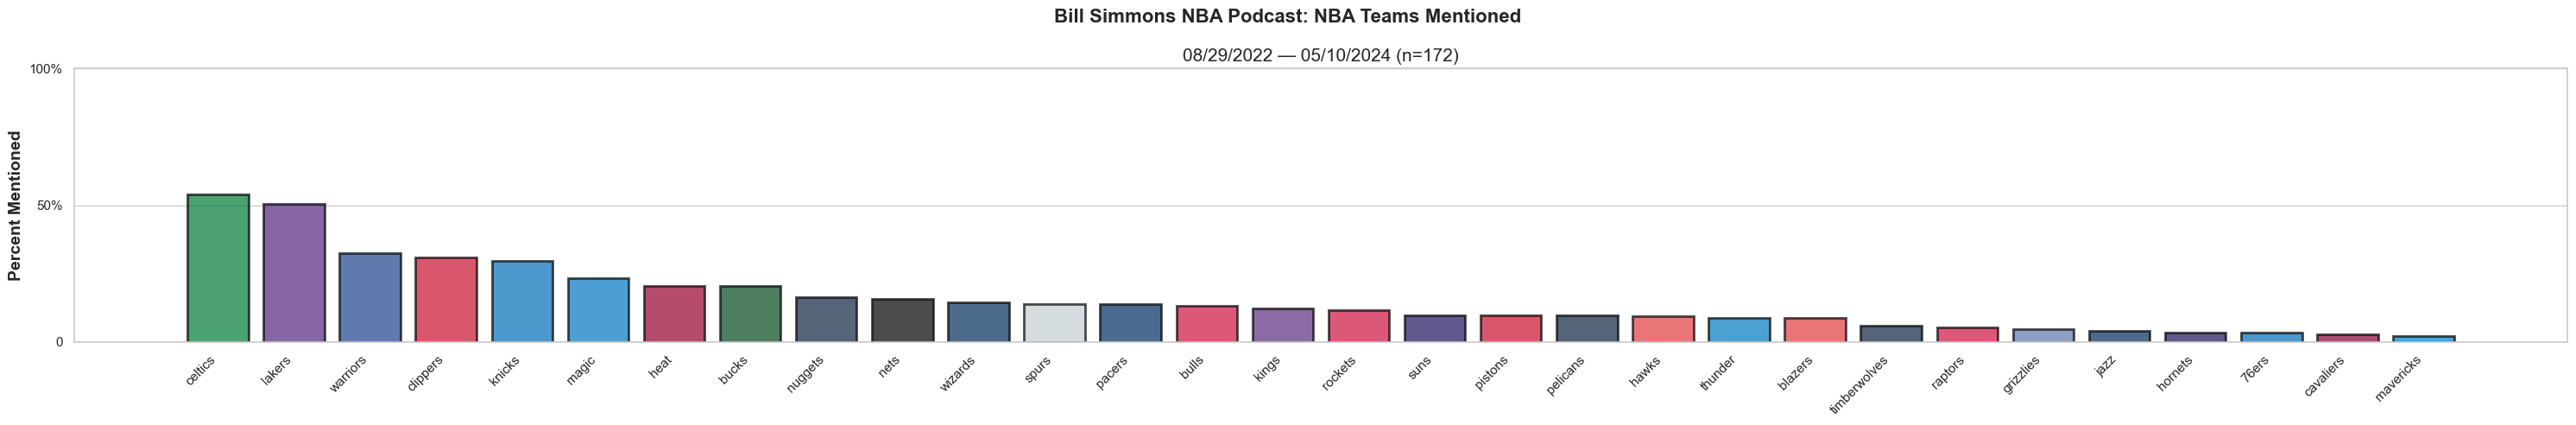

In [71]:
team_colors = {
    'lakers': '#552583',          # Purple and Gold
    'clippers': '#C8102E',        # Red and Blue
    'warriors': '#1D428A',        # Royal Blue and Gold
    'suns': '#1D1160',            # Purple, Orange, and Black
    'kings': '#5A2D81',           # Purple, Silver, and Black
    'mavericks': '#007DC5',       # Royal Blue, Navy Blue, and Silver
    'rockets': '#CE1141',         # Red and Silver
    'grizzlies': '#5D76A9',       # Navy Blue, Beige, and Slate Blue
    'pelicans': '#0C2340',        # Navy Blue, Gold, and Red
    'spurs': '#C4CED4',           # Silver, Black, and White
    'timberwolves': '#0C2340',    # Navy Blue, Lake Blue, and White
    'thunder': '#007AC1',         # Blue, Orange, and Yellow
    'nuggets': '#0E2240',         # Navy Blue, Gold, and Sky Blue
    'jazz': '#002B5C',            # Navy Blue, Gold, and Green
    'blazers': '#E03A3E',         # Red, Black, and White
    'heat': '#98002E',            # Red, Black, and White
    'magic': '#0077C0',           # Royal Blue, Silver, and Black
    'wizards': '#002B5C',         # Navy Blue, Red, and Silver
    'hawks': '#E03A3E',           # Red, Black, and Silver
    'hornets': '#1D1160',         # Purple, Teal, and White
    'nets': '#000000',            # Black and White
    'celtics': '#007A33',         # Green and White
    'knicks': '#006BB6',          # Royal Blue, Orange, and Silver
    '76ers': '#006BB6',           # Royal Blue, Red, and White
    'bucks': '#00471B',           # Hunter Green, Cream, and White
    'pacers': '#002D62',          # Navy Blue, Gold, and White
    'pistons': '#C8102E',         # Red, Blue, and White
    'bulls': '#CE1141',           # Red, Black, and White
    'cavaliers': '#860038',       # Wine, Gold, and Navy Blue
    'raptors': '#CE1141'          # Red, Black, and Silver
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(len(target_word_list), 5))

# add a column for the number of shows mentioned for each topic
for t_idx, topic in enumerate(target_word_list):
	# find the number of rows with max_fuzzy > 0.9 for the host
	topic_df = transcript_df[transcript_df[f'max_fuzzy_{topic}'] > 0.9]

# for each host find the number of rows with max_fuzzy > 0.9 and plot
num_mentions = []
for t_idx, topic in enumerate(target_word_list):
	# find the number of rows with max_fuzzy > 0.9 for the host
	topic_df = transcript_df[transcript_df[f'max_fuzzy_{topic}'] > 0.9]
	num_shows = topic_df.shape[0]/len(transcript_df)
	num_mentions.append(num_shows)

# sort the target_word_list by the number of shows mentioned
sorted_target_word_list = [x for _, x in sorted(zip(num_mentions, target_word_list), reverse=True)]
num_mentions = sorted(num_mentions, reverse=True)
# sort colors by the sorted target_word_list 
team_colors = {key: team_colors[key] for key in sorted_target_word_list}

plt.bar(range(len(target_word_list)), num_mentions, color=team_colors.values(), alpha=0.7, edgecolor='black', linewidth=2)
plt.ylim(0, 1)
plt.xticks(range(len(sorted_target_word_list)), sorted_target_word_list)
plt.yticks([0, 0.5, 1], ['0', '50%', '100%'])
# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percent Mentioned', fontsize=14, fontweight='bold')
plt.suptitle(f'{author_name} Podcast: NBA Teams Mentioned', fontsize=16, fontweight='bold')
# convert to mm/DD/YYYY
first_date = datetime.datetime.strptime(transcript_df['date'].iloc[-1], '%Y-%m-%d').strftime('%m/%d/%Y')
last_date = datetime.datetime.strptime(transcript_df['date'].iloc[0], '%Y-%m-%d').strftime('%m/%d/%Y')
plt.title(f'{first_date} — {last_date} (n={len(transcript_df)})', fontsize=15)
# reduce distance between sup and title
# only keep horizontal grid
plt.grid(axis='x')
# tight layout
plt.tight_layout()